In [133]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

In [134]:
cwd = os.getcwd()
cwd_ujoin = cwd.split("\\")[:-2]
basedir = "\\".join(cwd_ujoin)
sys.path.append(basedir)

In [135]:
from attitude.rigid_body import attitude_rate
from attitude.parameters import quat2dcm, dcm2quat

In [136]:
from attitude import x_tilde

In [137]:
def rw_sat_dynamics(q, w, rws, T_mtr, T_ext, gs_hat, I_SRW, J_s):
    ws = gs_hat.T@w

    # print(f"ws: {ws}")
    qdot = 0.5*np.array([
        [0,    -w[0], -w[1], -w[2]],
        [w[0],     0,  w[2], -w[1]],
        [w[1], -w[2],     0,  w[0]],
        [w[2],  w[1], -w[0],     0]
    ])@q
    # print(f"motor component wdot: {np.cross(w, J_s*gs_hat*ws*rws)}")
    wdot = np.linalg.inv(I_SRW)@(-np.cross(w, I_SRW@w) - np.cross(w, J_s*gs_hat*ws*rws) - T_mtr*gs_hat + T_ext)
    rws_dot = T_mtr/J_s - gs_hat.T@wdot
    # print(f"rx wheel acc: {rws_dot}")
    return qdot, wdot, rws_dot

In [138]:
def xdot(x, u_mtr, u_ext, gs_hat, I_SRW, J_s):
    qdot, wdot, rws_dot = rw_sat_dynamics(x[:4], x[4:7], x[7], u_mtr, u_ext, gs_hat, I_SRW, J_s)
    return np.hstack((qdot, wdot, rws_dot))

In [139]:
def predict(x, u_mtr, u_ext, gs_hat, I_SRW, J_s, start, end, **solver_opts):
    fx = lambda t, y: xdot(y, u_mtr, u_ext, gs_hat, I_SRW, J_s)
    sol = solve_ivp(fx, [start, end], x, rtol = 1e-5, **solver_opts)
    return sol.y.flatten()

In [140]:
def control(w, w_r, w_r_dot, I_SRW, P, gs_hat, J_s, rws):
    w_tilde = x_tilde(w)
    ws = gs_hat.T@w
    print(f"gshat: {gs_hat}:: w: {w}:: ws:{ws}")
    return P@(w - w_r) - w_tilde@(I_SRW@w + gs_hat*(J_s*(ws + rws)) - w_r) - I_SRW@(w_r_dot - np.cross(w, w_r))

### Define Geometry

In [141]:
# moment of inertia of satellite (including RW assembly)
l, w, h = 10e-2, 10e-2, 10e-2
motor_mass = 200e-3 # 100grams
r_m2com = 5e-2 # 5cm
motor_extra_inertia = 2*motor_mass*r_m2com**2 # assuming offset mass at opposite side
motor_extra_inertia

0.0010000000000000002

In [142]:
base_axial_inertia = ((800e-3)/3)*(l/2)**2
I_sat = np.array([
    [base_axial_inertia+motor_extra_inertia, 0.0, 0.0],
    [0.0, base_axial_inertia+motor_extra_inertia, 0.0],
    [0.0, 0.0, base_axial_inertia]
])
I_sat

array([[0.00166667, 0.        , 0.        ],
       [0.        , 0.00166667, 0.        ],
       [0.        , 0.        , 0.00066667]])

In [143]:
I_sat

array([[0.00166667, 0.        , 0.        ],
       [0.        , 0.00166667, 0.        ],
       [0.        , 0.        , 0.00066667]])

In [144]:
m_disc = 100e-3
r_disc = 0.5e-2
I_disc_s = (m_disc*r_disc**2)/2
I_disc_t = I_disc_s/2
J_s = I_disc_s
J_t = I_disc_t
J_g = I_disc_t

In [145]:
J_s

1.25e-06

In [146]:
gs_hat = np.array([0.0, 0.0, 1.0])
gt_hat = np.array([0.0, 1.0, 0.0])
gg_hat = np.array([1.0, 0.0, 0.0])

In [147]:
I_SRW = I_sat + J_t*gt_hat.reshape((3,1))@gt_hat.reshape((1,3)) + J_g*gg_hat.reshape((3,1))@gg_hat.reshape((1,3))
I_SRW

array([[0.00166729, 0.        , 0.        ],
       [0.        , 0.00166729, 0.        ],
       [0.        , 0.        , 0.00066667]])

### Define Initial Conditions

In [148]:
q0 = np.array([1.0, 0.0, 0.0, 0.0])
w0 = np.array([0.0, 0.0, 0.0])
rws0 = 0.0 # reaction wheel speed
x0 = np.hstack((q0, w0, rws0))
qt = np.array([0.0, 0.0, 0.0, 1.0])
wt = np.array([0.0, 0.0, 0.0])
wt_dot = np.deg2rad(np.array([0.0, 0.0, 0.0]))
xt = np.hstack((qt, wt)) #no rx wheel target
u0_ext = np.array([0.0, 0.0, 0.0])
u0_mtr = 0.0
u0 = np.array([0.0, 0.0, 0.0])

In [149]:
BN = quat2dcm(q0)
TN = quat2dcm(qt)
qr0 = dcm2quat(BN@TN.T)

In [150]:
t_start = 0
t_end = 180
dt = 0.5
t_vec = np.arange(t_start, t_end + dt, dt)

In [151]:
from tqdm import tqdm

In [152]:
x = x0
u = u0
u_ext = u0_ext
qr = qr0
x_history = np.zeros((len(t_vec), len(x)))
u_history = np.zeros((len(t_vec), len(u)))
solver_opts = dict(t_eval=[0])
Kq = 1e-4
K = 0.1e-2*np.array([
    [0.1,  0,  0],
    [0, 0.1, 0],
    [0, 0,  0.1]
])
errp = 0
errn = errp
err_total = 0

for idx, t in enumerate(t_vec):
    print(f"time step: {idx}")
    uq = Kq*qr[1:]
    uw = control(x[4:7], wt, wt_dot, I_SRW, K, gs_hat, J_s, x[7]) #w, w_r, w_r_dot, I_SRW, P, gs_hat, J_s, rws
    u = (uq + uw)[2]
    # print(f"state: {x}")
    # print(f"control effort: {u}")
    x_history[idx, :] = x
    u_history[idx, :] = u
    start = t
    end = t + dt
    solver_opts['t_eval'] = [end]
    xnew = predict(x, u, u_ext, gs_hat, I_SRW, J_s, start, end, **solver_opts)
    x = xnew
    BN = quat2dcm(x[:4])
    TN = quat2dcm(qt)
    qr = dcm2quat(BN@TN.T)

time step: 0
gshat: [0. 0. 1.]:: w: [0. 0. 0.]:: ws:0.0
time step: 1
gshat: [0. 0. 1.]:: w: [ 0.          0.         -0.04960784]:: ws:-0.049607837082461095
time step: 2
gshat: [0. 0. 1.]:: w: [ 0.          0.         -0.09549454]:: ws:-0.09549454137975198
time step: 3
gshat: [0. 0. 1.]:: w: [ 0.          0.         -0.13793189]:: ws:-0.13793189266455358
time step: 4
gshat: [0. 0. 1.]:: w: [ 0.          0.         -0.17715427]:: ws:-0.17715426545634788
time step: 5
gshat: [0. 0. 1.]:: w: [ 0.         0.        -0.2133534]:: ws:-0.2133534017605126
time step: 6
gshat: [0. 0. 1.]:: w: [ 0.          0.         -0.24667617]:: ws:-0.24667616676197532
time step: 7
gshat: [0. 0. 1.]:: w: [ 0.          0.         -0.27722502]:: ws:-0.2772250196279442
time step: 8
gshat: [0. 0. 1.]:: w: [ 0.          0.         -0.30506113]:: ws:-0.3050611335344149
time step: 9
gshat: [0. 0. 1.]:: w: [ 0.          0.         -0.33021022]:: ws:-0.33021021552476054
time step: 10
gshat: [0. 0. 1.]:: w: [ 0.        

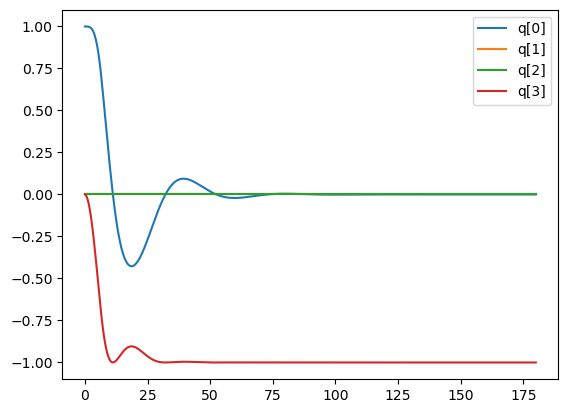

In [153]:
plt.plot(t_vec, x_history[:, :4])
plt.legend(["q[0]", "q[1]", "q[2]", "q[3]"])

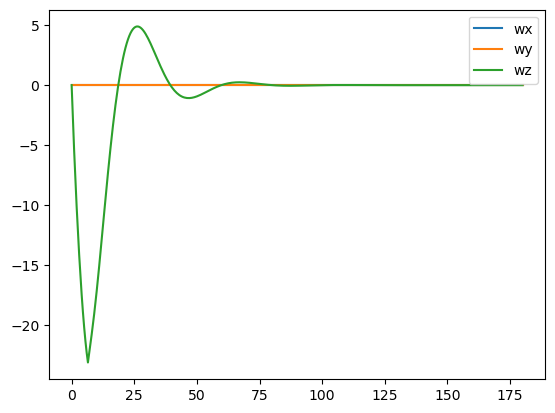

In [154]:
plt.plot(t_vec, np.rad2deg(x_history[:, 4:7]))
plt.legend(["wx", "wy", "wz"])

(-0.5, 2.0)

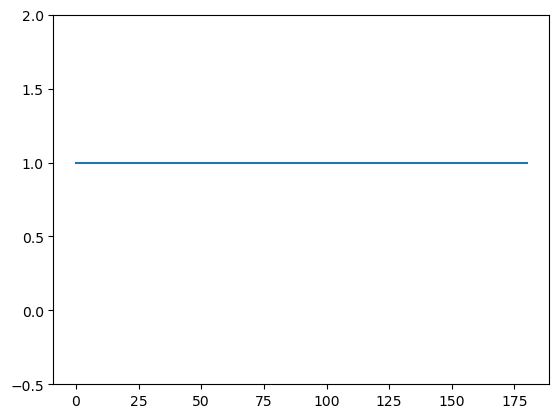

In [155]:
plt.plot(t_vec, np.linalg.norm(x_history[:, :4], axis=1))
plt.ylim(-0.5, 2)

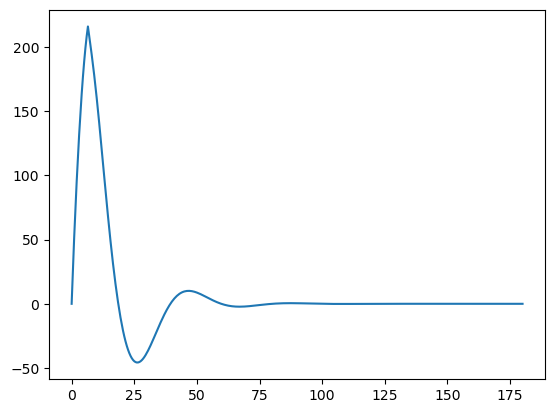

In [156]:
plt.plot(t_vec, x_history[:, 7])

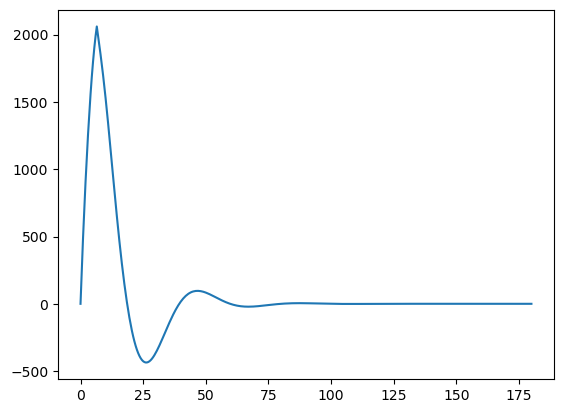

In [157]:
plt.plot(t_vec, x_history[:, 7]*(60/(2*np.pi)))

In [168]:
control(np.array([0, 0, 2.0]), np.array([0, 0, 1.0]), np.array([0, 0, 0]), I_SRW, K, gs_hat, J_s, 2)

gshat: [0. 0. 1.]:: w: [0. 0. 2.]:: ws:2.0


array([0.    , 0.    , 0.0001])